<a href="https://colab.research.google.com/github/wander-asb/MRI_CLASSIFICATION/blob/main/MRI_CLASSIFICATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importação de Bibliotecas

In [30]:

import torch
import numpy               as np
import pandas              as pd
import matplotlib.pyplot   as plt
import cv2                 as cv 
import matplotlib.pyplot   as plt
import torch.nn.functional as F

from google.colab            import drive
from google.colab.patches    import cv2_imshow
from skimage                 import io
from PIL                     import Image
from torch                   import nn, optim
from torchvision             import datasets, transforms
from sklearn.model_selection import train_test_split


print("Versão:",torch.__version__)

Versão: 1.9.0+cu111


In [31]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Modelo de arquitetura CNN

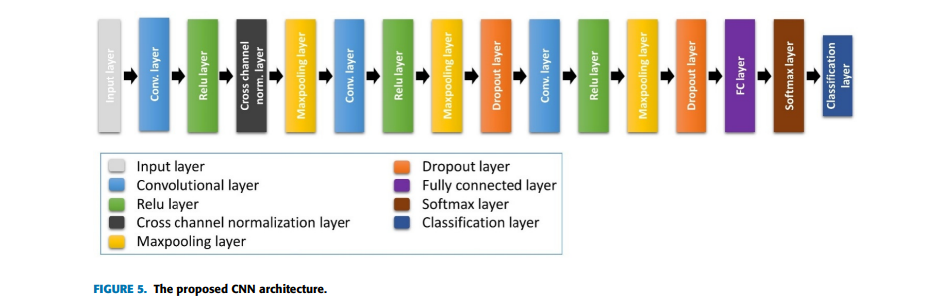

In [44]:
#Exemplo de arquitetura CNN
url = '/content/gdrive/MyDrive/MRI_TUMOR_CNN/Images/multi-classification architecture CNN.png'
img = io.imread(url)
cv2_imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

No exemplo acima, podemos verificar que o modelo de CNN inicia-se (input) pelo número de subcamadas por canais de cores, isto é, rgb ou por escalas de cinza. Logo, nosso in_features da primera camada será 3 ou 1, respectivamente. De forma que, as arquiteturas de CNN mantém uma composição típica, definida por compor a convolução, a função de ativação, seguida por uma camada de pooling e assim em diente.

In [33]:
class classificador(nn.Module):
    def __init__ (self):
        super().__init__()
      
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=10, stride=(1,1), padding=(0,0))
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=(1,1), padding=(2,2))
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=(1,1), padding=(2,2))

        self.activation = nn.ReLU() 
        self.bnorm = nn.BatchNorm2d(num_features=128)
        self.pool = nn.MaxPool2d(kernel_size=(2,2))
        
        self.flatten = nn.Flatten()
        
        self.linear1 = nn.Linear(in_features=32768, out_features=256)
        self.linear2 = nn.Linear(in_features=256, out_features=128)
        self.output = nn.Linear(in_features=128, out_features=4)

        self.dropout1 = nn.Dropout(p = 0.1)
        self.dropout2 = nn.Dropout(p = 0.2)
        
    def forward(self, X):
        X = self.pool(self.bnorm(self.activation(self.conv1(X))))
        X = self.dropout1(self.pool(self.activation(self.conv2(X))))
        X = self.dropout2(self.pool(self.activation(self.conv3(X))))
        X = self.flatten(X)
        
        X = self.activation(self.linear1(X))
        X = self.activation(self.linear2(X))
        X = self.output(X)
        
        return X

In [35]:
path_train = '/content/gdrive/MyDrive/MRI_TUMOR_CNN/DadosClassificacaoTumor/Training'
path_test = '/content/gdrive/MyDrive/MRI_TUMOR_CNN/DadosClassificacaoTumor/Testing'

In [36]:
transform_train = transforms.Compose(
    [
     transforms.Resize([128,128]),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomAffine(degrees=45, translate=(0, 0.07), shear=0.2, scale=(1,1.2)),
        transforms.ToTensor()
    ]
)

transform_test = transforms.Compose(
    [
     transforms.Resize([128,128]),
     transforms.ToTensor()
    ]
)

In [37]:
train_dataset = datasets.ImageFolder(path_train, transform=transform_train)
test_dataset = datasets.ImageFolder(path_test, transform=transform_test)

In [38]:
print(train_dataset, '\n', test_dataset)

Dataset ImageFolder
    Number of datapoints: 2870
    Root location: /content/gdrive/MyDrive/MRI_TUMOR_CNN/DadosClassificacaoTumor/Training
    StandardTransform
Transform: Compose(
               Resize(size=[128, 128], interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           ) 
 Dataset ImageFolder
    Number of datapoints: 394
    Root location: /content/gdrive/MyDrive/MRI_TUMOR_CNN/DadosClassificacaoTumor/Testing
    StandardTransform
Transform: Compose(
               Resize(size=[128, 128], interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


In [39]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=12, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=12, shuffle=True)

In [40]:
net = classificador()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [41]:
#Setamos a GPU necessária para realizar nossa classificação
device = torch.device("cuda") if torch.cuda.is_available else torch.device("cpu")
print(device)

net.to(device)


cuda


classificador(
  (conv1): Conv2d(3, 128, kernel_size=(10, 10), stride=(1, 1))
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1), padding=(2, 2))
  (activation): ReLU()
  (bnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=32768, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=4, bias=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [42]:
def training_loop(loader, epoch):
    running_loss = 0.
    running_accuracy = 0.
    for i, data in enumerate(loader):
        
        inputs, labels = data
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
        ps = F.softmax(outputs, dim=1)
        top_p, top_class = ps.topk(k=1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        
        accuracy= torch.mean(equals.type(torch.float))
        
        running_accuracy += accuracy
        
        #Imprimir os dados referentes a este loop
        print("Época {:3d} - Loop {:3d} de {:3d}: perda {:03.2f} - precisão {:03.2f}".format(epoch + 1, i+1, len(loader)\
                                                                                             , loss, accuracy), end= '\r')
    #Impressão referente à épocas
    print("Época {:3d} Finalizada: perda {:.5f} - precisão {:.5f}".format(epoch+1, running_loss/len(loader)\
                                                                         ,running_accuracy/len(loader)))

In [43]:
for epoch in range(20):
    print("Treinando...")
    training_loop(train_loader, epoch)
    net.eval()
    print('Validando...')
    training_loop(test_loader, epoch)
    net.train()

Treinando...
Época   1 Finalizada: perda 0.76492 - precisão 0.67465
Validando...
Época   1 Finalizada: perda 1.28920 - precisão 0.48030
Treinando...
Época   2 Finalizada: perda 0.49054 - precisão 0.81424
Validando...
Época   2 Finalizada: perda 1.15261 - precisão 0.54697
Treinando...
Época   3 Finalizada: perda 0.39180 - precisão 0.84479
Validando...
Época   3 Finalizada: perda 0.83364 - precisão 0.68030
Treinando...
Época   4 Finalizada: perda 0.29242 - precisão 0.88403
Validando...
Época   4 Finalizada: perda 0.65059 - precisão 0.74848
Treinando...
Época   5 Finalizada: perda 0.27183 - precisão 0.89757
Validando...
Época   5 Finalizada: perda 0.66044 - precisão 0.75707
Treinando...
Época   6 Finalizada: perda 0.22961 - precisão 0.91181
Validando...
Época   6 Finalizada: perda 0.62070 - precisão 0.78434
Treinando...
Época   7 Finalizada: perda 0.16553 - precisão 0.94063
Validando...
Época   7 Finalizada: perda 0.47161 - precisão 0.83232
Treinando...
Época   8 Finalizada: perda 0.14810